In [1]:
import collections
import sys

def process_corpus(file_name):
    """
    Reads a corpus file and organizes words by their length.

    Args:
        file_name (str): The path to the corpus.txt file.

    Returns:
        dict: A dictionary where keys are word lengths and values
              are lists of words (in uppercase).
    """
    # Use defaultdict to automatically initialize an empty list
    words_by_length = collections.defaultdict(list)

    try:
        with open(file_name, 'r') as f:
            for line in f:
                # 1. Strip whitespace (like \n)
                # 2. Convert to uppercase (to standardize)
                word = line.strip().upper()

                # Ensure the word is alphabetic (filters out any junk)
                if word.isalpha():
                    # 3. Add the word to the list for its specific length
                    words_by_length[len(word)].append(word)

    except FileNotFoundError:
        print(f"Error: The file '{file_name}' was not found.")
        print("Please check your 'Input' folder name on Kaggle.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    # Convert defaultdict back to a regular dict for cleaner output
    return dict(words_by_length)

# --- --- --- --- --- --- --- --- --- ---
# Run the function (Edited for Kaggle paths)
# --- --- --- --- --- --- --- --- --- ---
corpus_file_path = '../input/sooper/corpus.txt'
test_file_path = '../input/sooper/test.txt'

print(f"Attempting to read corpus file from: {corpus_file_path}")
word_lists = process_corpus(corpus_file_path)

print(f"Attempting to read test file from: {test_file_path}")
test_words = process_corpus(test_file_path)


if word_lists and test_words:
    # Print a sample to verify it worked
    print(f"\nSuccessfully processed corpus.txt.")
    print("--- Corpus Sample ---")
    print(f"Found {len(word_lists.get(5, []))} 5-letter words.")
    print(f"Example 5-letter words: {word_lists.get(5, ['N/A'])[:10]}")
    
    print(f"\nSuccessfully processed test.txt.")
    print("--- Test Set Sample ---")
    print(f"Found {len(test_words.get(7, []))} 7-letter words.")
    print(f"Example 7-letter words: {test_words.get(7, ['N/A'])[:10]}")
else:
    print("\nError: One or both files could not be loaded. Please verify the folder name 'sooper'.")

Attempting to read corpus file from: ../input/sooper/corpus.txt
Attempting to read test file from: ../input/sooper/test.txt

Successfully processed corpus.txt.
--- Corpus Sample ---
Found 2340 5-letter words.
Example 5-letter words: ['UNBED', 'UPBID', 'LINGE', 'BIRMA', 'BROCK', 'DANKE', 'APAID', 'BESOT', 'LENAD', 'CUMYL']

Successfully processed test.txt.
--- Test Set Sample ---
Found 205 7-letter words.
Example 7-letter words: ['TRUSTEE', 'SEXTOLE', 'SHAWLED', 'CRESSED', 'UPCROWD', 'DEMENCY', 'POULARD', 'ROTAMAN', 'TOTONAC', 'DULLITY']


2nd order hmm parameters 

In [2]:
import numpy as np
import collections
import json

# --- Helper Functions ---
def char_to_int(char):
    """Maps 'A'-'Z' to 0-25."""
    return ord(char) - ord('A')

def pair_to_int(c1, c2):
    """Maps a pair of chars ('A','A') to 0, ('A','B') to 1, ..., ('Z','Z') to 675."""
    return (ord(c1) - ord('A')) * 26 + (ord(c2) - ord('A'))

# --- Main Function ---
def calculate_hmm_parameters_2nd_order(word_lists_by_length):
    """
    Calculates 2nd-Order (trigram) HMM parameters.
    
    Returns:
        dict: {length: {'pi': pi_matrix, 'A': A_matrix}}
              - 'pi' is a 26x26 matrix for P(s1, s2)
              - 'A' is a 676x26 matrix for P(sk | sk-2, sk-1)
    """
    
    hmm_params_2nd = {}
    alphabet_size = 26
    pair_size = alphabet_size * alphabet_size # 676
    
    print("Calculating 2nd-Order HMM parameters...")
    
    for length, word_list in word_lists_by_length.items():
        if not word_list or length < 3: # Need at least 3 chars for a trigram
            continue
            
        # 1. Initialize count matrices
        # pi: Start pair probabilities P(s1, s2) -> (26x26)
        pi = np.zeros((alphabet_size, alphabet_size))
        # A: Transition probabilities P(sk | sk-2, sk-1) -> (676x26)
        A = np.zeros((pair_size, alphabet_size))
        
        num_words = len(word_list)
        
        for word in word_list:
            # 2. Count Start Probabilities (first pair)
            pi[char_to_int(word[0]), char_to_int(word[1])] += 1
            
            # 3. Count Transition Probabilities (trigrams)
            for i in range(2, length):
                # We are predicting char 'i'
                c1 = word[i-2] # sk-2
                c2 = word[i-1] # sk-1
                c3 = word[i]   # sk
                
                pair_idx = pair_to_int(c1, c2)
                char_idx = char_to_int(c3)
                
                A[pair_idx, char_idx] += 1
                
        # 4. Normalize to get probabilities (with Laplace smoothing)
        
        # Normalize pi
        pi_smooth = pi + 1
        pi = pi_smooth / (num_words + (alphabet_size**2))
        
        # Normalize A
        A_smooth = A + 1
        # Sum each row (e.g., sum of all letters that can follow 'AP')
        row_sums = A_smooth.sum(axis=1)[:, np.newaxis] 
        A = A_smooth / row_sums
        
        # Store the calculated parameters
        hmm_params_2nd[length] = {'pi': pi, 'A': A}

    print("2nd-Order HMM parameters calculated.")
    return hmm_params_2nd

# --- --- --- --- --- --- --- --- --- --- 
# Run the function
# (Assuming 'word_lists' exists from the previous cell)
# --- --- --- --- --- --- --- --- --- --- 
hmm_params_2nd_order = calculate_hmm_parameters_2nd_order(word_lists)

# --- --- --- --- --- --- --- --- --- --- 
# Save the new HMM Parameters
# --- --- --- --- --- --- --- --- --- --- 
try:
    serializable_params = {
        length: {
            'pi': params['pi'].tolist(), 
            'A': params['A'].tolist()
        } 
        for length, params in hmm_params_2nd_order.items()
    }
    
    # Save to a new file name
    with open('hmm_params_2nd_order.json', 'w') as f:
        json.dump(serializable_params, f)
    
    print("Successfully saved 2nd-Order HMM parameters to 'hmm_params_2nd_order.json'.")

except Exception as e:
    print(f"Error saving HMM parameters to JSON: {e}")

Calculating 2nd-Order HMM parameters...
2nd-Order HMM parameters calculated.
Successfully saved 2nd-Order HMM parameters to 'hmm_params_2nd_order.json'.


hangmanenv

In [3]:
import numpy as np
import random
import json

# --- Helper Function ---
def char_to_int(char):
    return ord(char) - ord('A')

class HangmanEnv:
    
    def __init__(self, word_lists, hmm_params, hmm_oracle_func):
        self.word_lists_by_length = word_lists
        # Only use lengths we have HMMs for
        self.all_lengths = sorted([l for l in word_lists.keys() if l in hmm_params]) 
        self.hmm_params = hmm_params
        self.hmm_oracle_func = hmm_oracle_func
        self.secret_word = ""
        self.current_pattern = ""
        self.guessed_letters = set()
        self.lives_left = 6
        self.alphabet_size = 26

    def _get_state(self):
        """
        Generates the 54-dimensional state vector for the RL agent.
        
        State Vector:
        - Dims 0-25: Binary vector of guessed letters.
        - Dim 26: Normalized lives left.
        - Dims 27-52: 26-element probability vector from the HMM oracle.
        - Dim 53: NEW: Normalized blanks remaining.
        """
        # 1. Guessed letters vector
        guessed_vec = np.zeros(self.alphabet_size)
        for char in self.guessed_letters:
            guessed_vec[char_to_int(char)] = 1.0
            
        # 2. Normalized lives
        lives_vec = np.array([self.lives_left / 6.0])
        
        # 3. HMM Probability vector
        hmm_probs = self.hmm_oracle_func(
            self.current_pattern, 
            self.guessed_letters, 
            self.hmm_params
        )
        
        # 4. *** NEW FEATURE *** Normalized blanks remaining
        blanks_remaining = self.current_pattern.count('_')
        total_length = len(self.secret_word)
        # Use total_length or 1 to avoid division by zero if length is 0
        normalized_blanks = np.array([blanks_remaining / (total_length or 1.0)]) 
        
        # Concatenate all parts into one state vector
        state = np.concatenate([guessed_vec, lives_vec, hmm_probs, normalized_blanks])
        return state

    def reset(self, word=None, length=None):
        if word:
            self.secret_word = word.upper()
        else:
            if length and length in self.all_lengths:
                chosen_length = length
            else:
                # Ensure we have lengths to choose from
                if not self.all_lengths:
                    print("Error: No valid word lengths found in HMM params.")
                    self.secret_word = "ERROR" # Failsafe
                else:
                    chosen_length = random.choice(self.all_lengths)
                
            word_list = self.word_lists_by_length.get(chosen_length, ["DEFAULT"])
            if not word_list:
                 self.secret_word = "DEFAULT" # Failsafe
            else:
                 self.secret_word = random.choice(word_list)

        self.current_pattern = "_" * len(self.secret_word)
        self.guessed_letters = set()
        self.lives_left = 6
        return self._get_state()

    def step(self, action_int):
        """
        *SIMPLIFIED* step function. 
        Assumes agent will NEVER make a repeated guess.
        """
        action_char = chr(action_int + ord('A'))
        
        # --- Failsafe ---
        if action_char in self.guessed_letters:
            reward = -100 # Catastrophic penalty for bug
            done = True
            info = {'wrong': 0, 'repeated': 1, 'win': False}
            return self._get_state(), reward, done, info

        self.guessed_letters.add(action_char)
        reward = 0
        done = False
        info = {'wrong': 0, 'repeated': 0, 'correct': 0, 'win': False}

        # --- 1. Check for correct guess ---
        if action_char in self.secret_word:
            reward = +1  # Small reward for correct guess
            info['correct'] = 1
            new_pattern = ""
            for i, char in enumerate(self.secret_word):
                if char == action_char:
                    new_pattern += action_char
                else:
                    new_pattern += self.current_pattern[i]
            self.current_pattern = new_pattern
            
            # Check for WIN
            if "_" not in self.current_pattern:
                reward = +50  # Large reward for winning
                done = True
                info['win'] = True
        
        # --- 2. Check for wrong guess ---
        else:
            reward = -5  # Penalty for wrong guess
            self.lives_left -= 1
            info['wrong'] = 1
            
            # Check for LOSS
            if self.lives_left <= 0:
                reward = -50  # Large penalty for losing
                done = True
                info['win'] = False
        
        return self._get_state(), reward, done, info

2nd order hmm oracle function

In [4]:
import numpy as np
import json

# --- Helper Functions ---
def char_to_int(char):
    """Maps 'A'-'Z' to 0-25."""
    return ord(char) - ord('A')

def pair_to_int(c1, c2):
    """Maps a pair of chars ('A','A') to 0, ..., ('Z','Z') to 675."""
    return (ord(c1) - ord('A')) * 26 + (ord(c2) - ord('A'))

# Set numpy to ignore runtime warnings (e.g., divide by zero)
np.seterr(divide='ignore', invalid='ignore')

def get_letter_probabilities_2nd_order(pattern, guessed_letters, all_hmm_params_2nd_order):
    """
    The 2nd-Order (Trigram) HMM "Oracle".
    
    Calculates the probability of each *unguessed* letter appearing
    in any of the *blank* spots, using 2nd-order HMM parameters.
    """
    
    length = len(pattern)
    alphabet_size = 26
    
    # --- 1. Get HMM parameters for this length ---
    if length not in all_hmm_params_2nd_order:
        # Fallback for unknown lengths (e.g., < 3 or not in corpus)
        probs = np.ones(alphabet_size)
        for char in guessed_letters:
            if 0 <= char_to_int(char) < alphabet_size:
                probs[char_to_int(char)] = 0
        sum_probs = np.sum(probs)
        return probs / sum_probs if sum_probs > 0 else np.zeros(alphabet_size)

    params = all_hmm_params_2nd_order[length]
    # pi is P(s1, s2) -> (26, 26)
    pi_matrix = params['pi'] 
    # A is P(sk | sk-2, sk-1) -> (676, 26)
    A_trigram_matrix = params['A'] 
    # Reshape A for easier computation -> (26, 26, 26)
    # A_reshaped[i, j, k] = P(k | i, j)
    A_reshaped = A_trigram_matrix.reshape(alphabet_size, alphabet_size, alphabet_size)

    
    # --- 2. Build *Simple* Dynamic Emission Matrix (B) ---
    # P(Observation | State), where State is a *single letter*.
    # B_simple is (state, observation) -> (26, 27)
    B_simple = np.zeros((alphabet_size, alphabet_size + 1))
    
    obs_sequence = []
    for char in pattern:
        if char == '_':
            obs_sequence.append(26) # 26 = blank
        else:
            obs_sequence.append(char_to_int(char))

    for state_idx in range(alphabet_size):
        state_char = chr(state_idx + ord('A'))
        if state_char in guessed_letters:
            B_simple[state_idx, state_idx] = 1.0 # Must see this letter
        else:
            B_simple[state_idx, 26] = 1.0 # Must see a blank
            
            
    # --- 3. Forward Pass (alpha) ---
    # alpha[k, i, j] = P(O_1...O_k, s_k-1 = i, s_k = j)
    alpha = np.zeros((length, alphabet_size, alphabet_size))
    
    # Initialization (k=1, i.e., pos 2)
    O_0 = obs_sequence[0]
    O_1 = obs_sequence[1]
    alpha[1, :, :] = pi_matrix * B_simple[:, O_0][:, np.newaxis] * B_simple[:, O_1][np.newaxis, :]

    # Recursion (k >= 2)
    for k in range(2, length):
        O_k = obs_sequence[k]
        B_k = B_simple[:, O_k] # (26,)
        
        sum_over_i = np.einsum('ij,ijm->jm', alpha[k-1], A_reshaped)
        alpha[k] = sum_over_i * B_k[np.newaxis, :]
            
    # --- 4. Backward Pass (beta) ---
    # beta[k, i, j] = P(O_k+1...O_T | s_k-1 = i, s_k = j)
    beta = np.zeros((length, alphabet_size, alphabet_size))
    
    # Initialization (k=T-1, i.e., last position)
    beta[length-1, :, :] = 1.0
    
    # Recursion (k < T-1)
    for k in range(length - 2, 0, -1): # From L-2 down to 1
        O_k_plus_1 = obs_sequence[k+1]
        B_k_plus_1 = B_simple[:, O_k_plus_1] # (26,)
        
        term = A_reshaped * B_k_plus_1[np.newaxis, np.newaxis, :] * beta[k+1]
        beta[k] = np.sum(term, axis=2) # Sum over m
            
    # --- 5. Calculate Gamma (Smoothing Probabilities) ---
    gamma_pairs = np.zeros((length, alphabet_size, alphabet_size))
    for k in range(1, length):
        gamma_pairs[k] = alpha[k] * beta[k]
        total_sum = np.sum(gamma_pairs[k])
        if total_sum > 0:
            gamma_pairs[k] /= total_sum
        else:
            gamma_pairs[k] = np.nan_to_num(gamma_pairs[k])

    # --- 6. Get Single Letter Probabilities ---
    final_gamma_single = np.zeros((length, alphabet_size))
    
    # For k=0 (pos 1): P(s_0=i) = sum over j of P(s_0=i, s_1=j)
    final_gamma_single[0] = gamma_pairs[1].sum(axis=1) 
    
    # For k=1...L-1 (pos 2...T): P(s_k=j) = sum over i of P(s_k-1=i, s_k=j)
    for k in range(1, length):
        final_gamma_single[k] = gamma_pairs[k].sum(axis=0)

    # --- 7. Aggregate Probabilities for Blanks ---
    final_probs = np.zeros(alphabet_size)
    blank_indices = [i for i, char in enumerate(pattern) if char == '_']
    
    if not blank_indices:
        return final_probs 

    final_probs = np.sum(final_gamma_single[blank_indices, :], axis=0)

    # --- 8. Filter for Unguessed Letters ---
    for guessed_char in guessed_letters:
        final_probs[char_to_int(guessed_char)] = 0.0
        
    # --- 9. Final Normalization ---
    total_prob_sum = np.sum(final_probs)
    if total_prob_sum > 0:
        final_probs = final_probs / total_prob_sum
    else:
        for i in range(alphabet_size):
            if chr(i + ord('A')) not in guessed_letters:
                final_probs[i] = 1.0
        sum_probs = np.sum(final_probs)
        final_probs = final_probs / sum_probs if sum_probs > 0 else np.zeros(alphabet_size)
        
    return np.nan_to_num(final_probs)

DQNAgent Class

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import math
from collections import deque, namedtuple
import numpy as np

# --- 0. Helper Function ---
def char_to_int(char):
    """Maps 'A'-'Z' to 0-25."""
    return ord(char) - ord('A')

# --- 1. Define Hyperparameters ---
BUFFER_SIZE = 100000  # Replay buffer size
BATCH_SIZE = 64       # Mini-batch size for training
GAMMA = 0.99          # Discount factor for future rewards
LR = 0.0001           # Learning rate (as per our successful run)
TARGET_UPDATE = 10    # How often to update the target network (in episodes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Experience = namedtuple("Experience",
                        field_names=["state", "action", "reward", "next_state", "done"])

# --- 2. Replay Buffer Class (Unchanged) ---
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed=0):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
    
    def push(self, state, action, reward, next_state, done):
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# --- 3. Q-Network Class (Unchanged, but will accept 54-dim state) ---
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed=0, fc1_units=128, fc2_units=128):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --- 4. DQNAgent Class (Action Masking logic is unchanged) ---
class DQNAgent:
    def __init__(self, state_size, action_size, seed=0):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.q_network = QNetwork(state_size, action_size, seed).to(device)
        self.target_network = QNetwork(state_size, action_size, seed).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=LR)
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay_rate = 0.9995 

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
            
    def select_action(self, state, eps=None):
        if eps is None:
            eps = self.epsilon
            
        guessed_vec = state[0:26]
        
        if random.random() < eps:
            valid_actions = [i for i, guessed in enumerate(guessed_vec) if guessed == 0]
            if not valid_actions: return 0 
            return random.choice(valid_actions)
        else:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
            
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state_tensor)
            self.q_network.train()
            
            illegal_mask = (torch.from_numpy(guessed_vec) == 1).to(device)
            action_values[0][illegal_mask] = -float('inf')
            
            return np.argmax(action_values.cpu().data.numpy())

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next_all = self.target_network(next_states).detach()
        
        # *** STATE_SIZE CHANGE ***
        # The mask is still the first 26 elements, so this logic is correct
        next_guessed_vecs = next_states[:, 0:26] 
        illegal_actions_mask = (next_guessed_vecs == 1)
        Q_targets_next_all[illegal_actions_mask] = -float('inf')
        
        Q_targets_next = Q_targets_next_all.max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)
        
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay_rate * self.epsilon)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# --- 5. Initialization Test ---
print("\n--- Running FIXED Agent Initialization Test (54-dim) ---")
# *** STATE_SIZE CHANGE ***
STATE_SIZE = 54  # Guessed (26) + Lives (1) + HMM Probs (26) + Blanks (1)
ACTION_SIZE = 26 # Letters 'A'-'Z'
try:
    agent = DQNAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE, seed=0)
    print("SUCCESS: 54-dim DQNAgent initialized.")
    
    # Test action masking
    test_state = np.zeros(STATE_SIZE)
    test_state[char_to_int('A')] = 1 # Mark 'A' as guessed
    test_state[char_to_int('B')] = 1 # Mark 'B' as guessed
    
    actions_taken = [agent.select_action(test_state, eps=0.0) for _ in range(100)]
    if 0 in actions_taken or 1 in actions_taken:
        print("FAILURE: Action masking test failed.")
    else:
        print("SUCCESS: Action masking test passed.")

except Exception as e:
    print(f"FAILURE: Could not initialize agent. Error: {e}")

Using device: cuda

--- Running FIXED Agent Initialization Test (54-dim) ---
SUCCESS: 54-dim DQNAgent initialized.
SUCCESS: Action masking test passed.


Main Training & Evaluation Loop (Full Upgrade)

--- Part 5 (2nd-Order HMM): Starting Training Loop ---
Successfully loaded 'hmm_params_2nd_order.json'.
FIXED DQNAgent (54-dim) and HangmanEnv (2nd-Order HMM) initialized.
Episode 2000	Average Score (Last 100): -57.01	Epsilon: 0.3678
Episode 4000	Average Score (Last 100): -38.57	Epsilon: 0.1353
Episode 6000	Average Score (Last 100): -26.64	Epsilon: 0.0497
Episode 8000	Average Score (Last 100): -17.00	Epsilon: 0.0183
Episode 10000	Average Score (Last 100): -10.72	Epsilon: 0.0100
Episode 12000	Average Score (Last 100): 0.57	Epsilon: 0.010000
Episode 14000	Average Score (Last 100): -8.71	Epsilon: 0.01000
Episode 16000	Average Score (Last 100): -2.56	Epsilon: 0.01000
Episode 18000	Average Score (Last 100): 2.30	Epsilon: 0.010000
Episode 20000	Average Score (Last 100): -2.54	Epsilon: 0.01000
Episode 22000	Average Score (Last 100): -6.98	Epsilon: 0.0100
Episode 24000	Average Score (Last 100): -2.30	Epsilon: 0.01000
Episode 26000	Average Score (Last 100): -1.08	Epsilon: 0.0100
Episode 28000	A

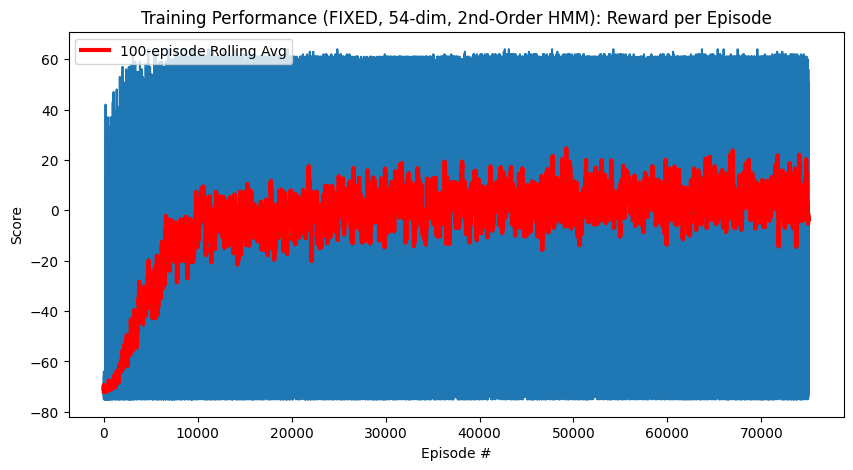

Done. Check 'learning_curve_v3.png' for the new plot.


In [6]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import deque
import time

# --- 1. Load 2nd-Order HMM Parameters ---
print("--- Part 5 (2nd-Order HMM): Starting Training Loop ---")
try:
    with open('hmm_params_2nd_order.json', 'r') as f:
        hmm_params_list = json.load(f)
    # *** NEW HMM PARAMS ***
    hmm_params_2nd = {
        int(length): {
            'pi': np.array(params['pi']),
            'A': np.array(params['A'])
        }
        for length, params in hmm_params_list.items()
    }
    print("Successfully loaded 'hmm_params_2nd_order.json'.")
except FileNotFoundError:
    print("FATAL ERROR: 'hmm_params_2nd_order.json' not found.")
    raise

# --- 2. Define Training Hyperparameters ---
NUM_EPISODES = 75000      # Using your last successful run's episode count
# *** STATE_SIZE CHANGE ***
STATE_SIZE = 54           
ACTION_SIZE = 26          
TARGET_UPDATE = 10        
MODEL_SAVE_PATH = 'hackman_dqn_v3.pth' # Save to a new file

# --- 3. Initialize Agent and Environment ---
# (Assumes word_lists, HangmanEnv, DQNAgent, and get_letter_probabilities_2nd_order are in memory)
try:
    agent = DQNAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE, seed=0)
    # *** INITIALIZE WITH NEW ORACLE AND PARAMS ***
    env = HangmanEnv(word_lists, hmm_params_2nd, get_letter_probabilities_2nd_order)
    print("FIXED DQNAgent (54-dim) and HangmanEnv (2nd-Order HMM) initialized.")
except Exception as e:
    print(f"FATAL ERROR: Could not initialize. {e}")
    raise

# --- 4. The Main Training Loop ---
start_time = time.time()
scores = []                         
scores_window = deque(maxlen=100)   

for i_episode in range(1, NUM_EPISODES + 1):
    state = env.reset()
    score = 0
    
    while True:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
            
    scores_window.append(score)
    scores.append(score)
    agent.update_epsilon()
    
    if i_episode % TARGET_UPDATE == 0:
        agent.update_target_network()
        
    if i_episode % 100 == 0:
        print(f'\rEpisode {i_episode}\tAverage Score (Last 100): {np.mean(scores_window):.2f}\tEpsilon: {agent.epsilon:.4f}', end="")
    if i_episode % 2000 == 0:
        print(f'\rEpisode {i_episode}\tAverage Score (Last 100): {np.mean(scores_window):.2f}\tEpsilon: {agent.epsilon:.4f}')

# --- 5. Save the Trained Model ---
torch.save(agent.q_network.state_dict(), MODEL_SAVE_PATH)
end_time = time.time()
print(f"\n--- Training Complete ---")
print(f"Total training time: {(end_time - start_time) / 60:.2f} minutes")
print(f"Model weights saved to '{MODEL_SAVE_PATH}'")


# ======================================================================
# --- Part 6: Evaluation and Analysis ---
# ======================================================================

print("\n\n--- Part 6: Starting Evaluation (2nd-Order HMM) ---")

def evaluate_agent(agent_to_eval, env_to_eval, test_word_lists, num_games=2000):
    print(f"Evaluating agent on {num_games} hidden words...")
    agent_to_eval.q_network.eval() 
    
    all_test_words = []
    for length, words in test_word_lists.items():
        if length in env_to_eval.hmm_params:
            all_test_words.extend(words)
    
    if not all_test_words:
        print("ERROR: No valid test words found.")
        return

    random.shuffle(all_test_words) # Shuffle to get a good random sample
    test_words_sample = all_test_words[:num_games]
    if len(test_words_sample) < num_games:
        num_games = len(test_words_sample)
        print(f"Warning: Test set has fewer than 2000 valid words. Evaluating on {num_games} words.")
        
    total_wins = 0
    total_wrong_guesses = 0
    total_repeated_guesses = 0
    
    for word in test_words_sample:
        state = env_to_eval.reset(word=word)
        ep_wrong = 0
        ep_repeated = 0
        done = False
        
        while not done:
            action = agent_to_eval.select_action(state, eps=0.0) 
            next_state, _, done, info = env_to_eval.step(action)
            ep_wrong += info.get('wrong', 0)
            ep_repeated += info.get('repeated', 0)
            state = next_state
            
            if done:
                if info.get('win', False):
                    total_wins += 1
                break
                
        total_wrong_guesses += ep_wrong
        total_repeated_guesses += ep_repeated
        
    success_rate = total_wins / num_games
    final_score = (success_rate * 2000) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)
    
    print("\n--- Evaluation Complete: Final Results ---")
    print(f"Games Played:           {num_games}")
    print(f"Wins:                   {total_wins} (Success Rate: {success_rate * 100:.2f}%)")
    print("------------------------------------------")
    print(f"Total Wrong Guesses:    {total_wrong_guesses}")
    print(f"Total Repeated Guesses: {total_repeated_guesses}")
    print("------------------------------------------")
    print(f"Avg. Wrong Guesses:     {total_wrong_guesses / num_games:.2f}")
    print(f"Avg. Repeated Guesses:  {total_repeated_guesses / num_games:.2f}")
    print("------------------------------------------")
    print(f"FINAL SCORE:            {final_score:.2f}")
    print("==========================================")
    

# --- Run the Evaluation ---
# *** STATE_SIZE CHANGE ***
evaluation_agent = DQNAgent(state_size=STATE_SIZE, action_size=ACTION_SIZE, seed=0)
evaluation_agent.q_network.load_state_dict(torch.load(MODEL_SAVE_PATH))
evaluation_agent.q_network.to(device)

# (env and test_words should be in memory)
evaluate_agent(evaluation_agent, env, test_words, num_games=2000)

# --- Plot Learning Curve ---
print("\nPlotting learning curve...")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Training Performance (FIXED, 54-dim, 2nd-Order HMM): Reward per Episode')
rolling_avg = [np.mean(scores[max(0, i-100):i+1]) for i in range(len(scores))]
plt.plot(rolling_avg, color='red', linewidth=3, label='100-episode Rolling Avg')
plt.legend()
plt.savefig('learning_curve_v3.png')
plt.show()
print("Done. Check 'learning_curve_v3.png' for the new plot.")

In [7]:
import torch

# --- Assuming 'agent' is your fully trained agent variable ---
MODEL_SAVE_PATH_PKL = 'hackman_dqn_v3.pkl'

try:
    # Save just the model's weights (the state_dict)
    torch.save(agent.q_network.state_dict(), MODEL_SAVE_PATH_PKL)
    
    print(f"\n--- SUCCESS ---")
    print(f"Model weights (state_dict) successfully saved to: {MODEL_SAVE_PATH_PKL}")
    print("You can now find this file in the 'Output' section in the right-hand sidebar.")
    
except Exception as e:
    print(f"An error occurred while saving: {e}")


--- SUCCESS ---
Model weights (state_dict) successfully saved to: hackman_dqn_v3.pkl
You can now find this file in the 'Output' section in the right-hand sidebar.
